In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

In [44]:
predictions_dict = {}

In [45]:
config_filename = 'bokaro.yaml'
config = read_config(config_filename)

In [46]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
fetching from athenadb...
loading from ../../misc/cache/dataframes_ts_28102020_athena.pkl
splitting data ..
splitting data ..
           state district       date   total  active  recovered  deceased  \
0    maharashtra   mumbai 2020-04-11    1182    1036         71        75   
1    maharashtra   mumbai 2020-04-12    1399    1211         97        91   
2    maharashtra   mumbai 2020-04-13    1549    1308        141       100   
3    maharashtra   mumbai 2020-04-14    1753    1478        164       111   
4    maharashtra   mumbai 2020-04-15    1936    1642        181       113   
..           ...      ...        ...     ...     ...        ...       ...   
187  maharashtra   mumbai 2020-10-15  236725   20922     203467      9598   
188  maharashtra   mumbai 2020-10-16  241939   18062     210813      9731   
189  maharashtra   mumbai 2020-10-17  240339   18717     208099      9682   
190  maharashtra   mumbai 2020-10-18  241939   18062     210813      9731   
191  m

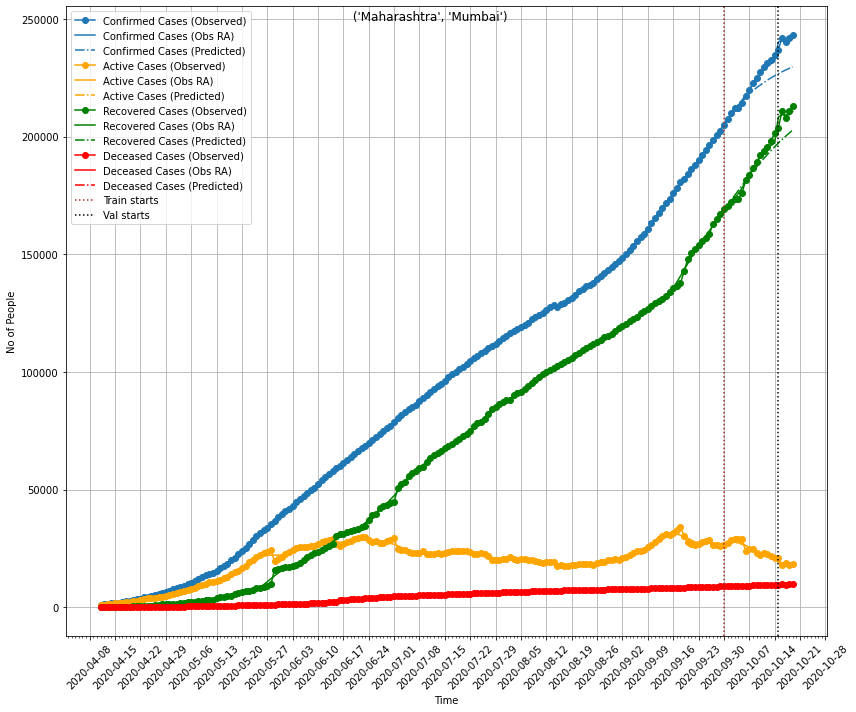

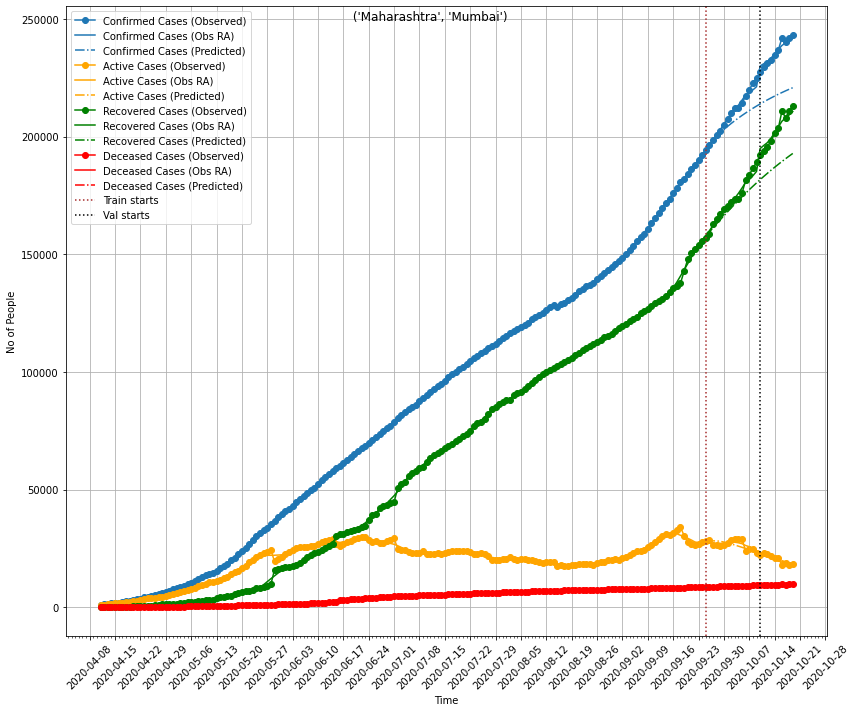

In [47]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)
# predictions_dict['m2'] = predictions_dict['m1']

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [48]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.14208474501679344,
 'I_hosp_ratio': 0.37230584788072535,
 'P_fatal': 0.03142082193859604,
 'T_inc': 4.127228573850715,
 'T_inf': 3.4191571037517843,
 'T_recov': 12.590997054959354,
 'T_recov_fatal': 13.52040703213448,
 'lockdown_R0': 0.9502421801975616}

In [49]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.1024041175271414,
 'I_hosp_ratio': 0.34534268121607575,
 'P_fatal': 0.0317771046447744,
 'T_inc': 4.883875949280568,
 'T_inf': 3.600053472021835,
 'T_recov': 15.949443258375684,
 'T_recov_fatal': 27.111334384078646,
 'lockdown_R0': 1.1140909742984282}

## Loss Dataframes

In [ ]:
predictions_dict['m2']['df_data_weights_val']

### M1 Loss DataFrame

In [50]:
predictions_dict['m1']['df_loss']

train      val
total      1.26223  5.21452
active     3.67092  4.47505
recovered  1.29882  4.28894
deceased   1.60193  2.05441

### M2 Loss DataFrame

In [51]:
predictions_dict['m2']['df_loss']

train      val
total       1.54173  8.15869
active      4.95514   3.4906
recovered   2.34016  7.48995
deceased   0.965575  2.03549

## Sensitivity Plot

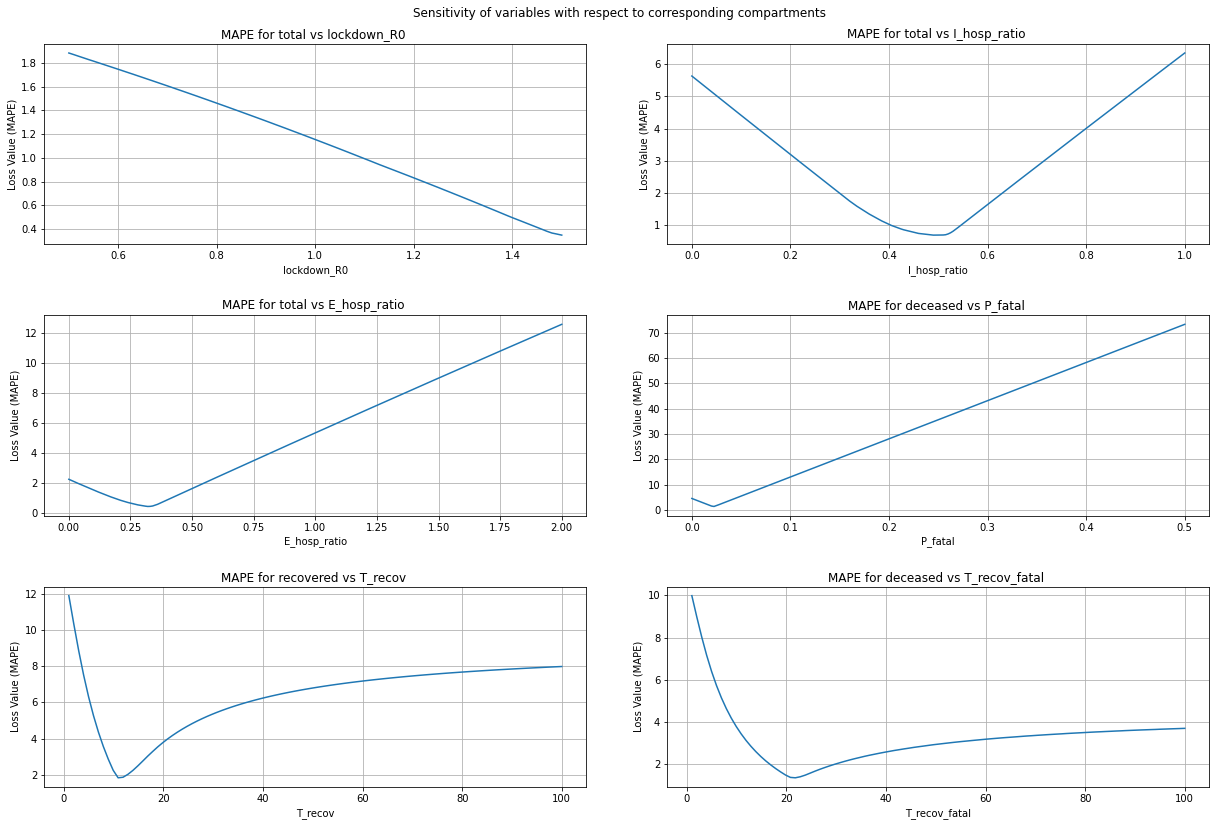

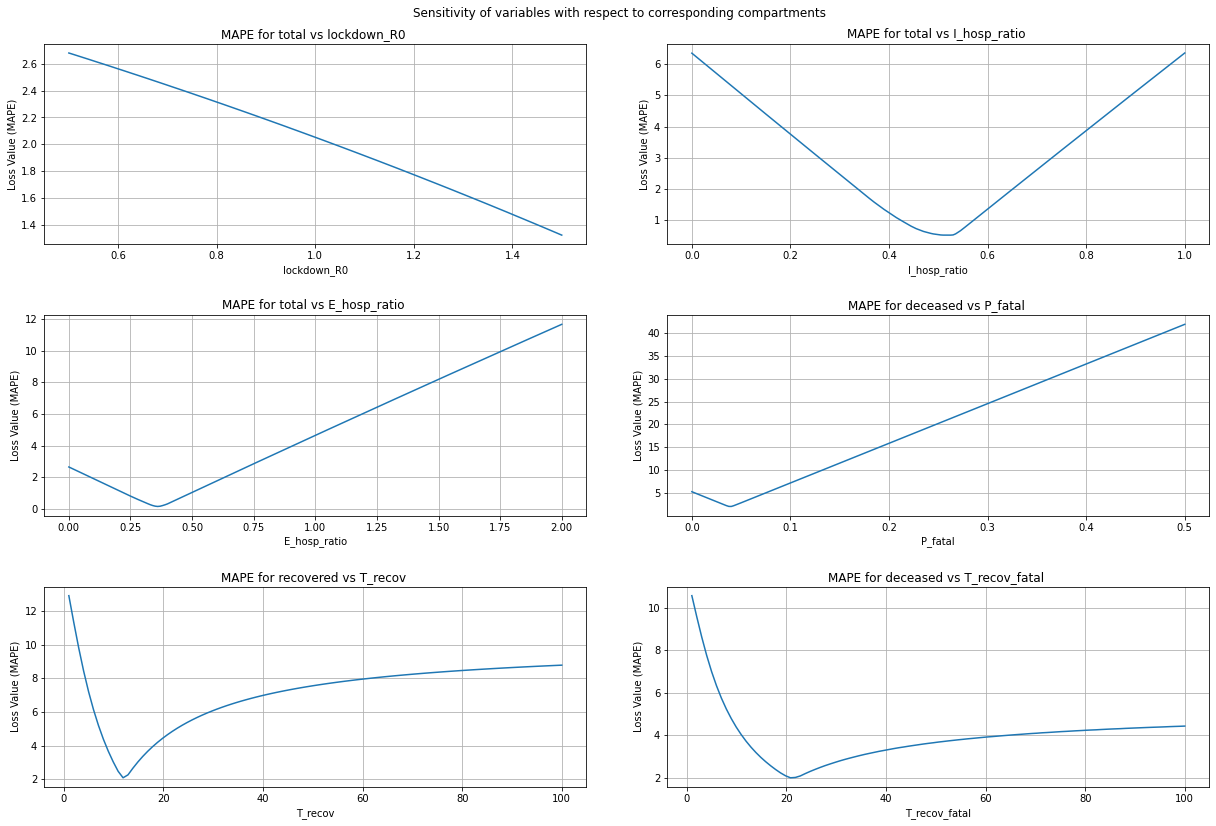

In [52]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [53]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


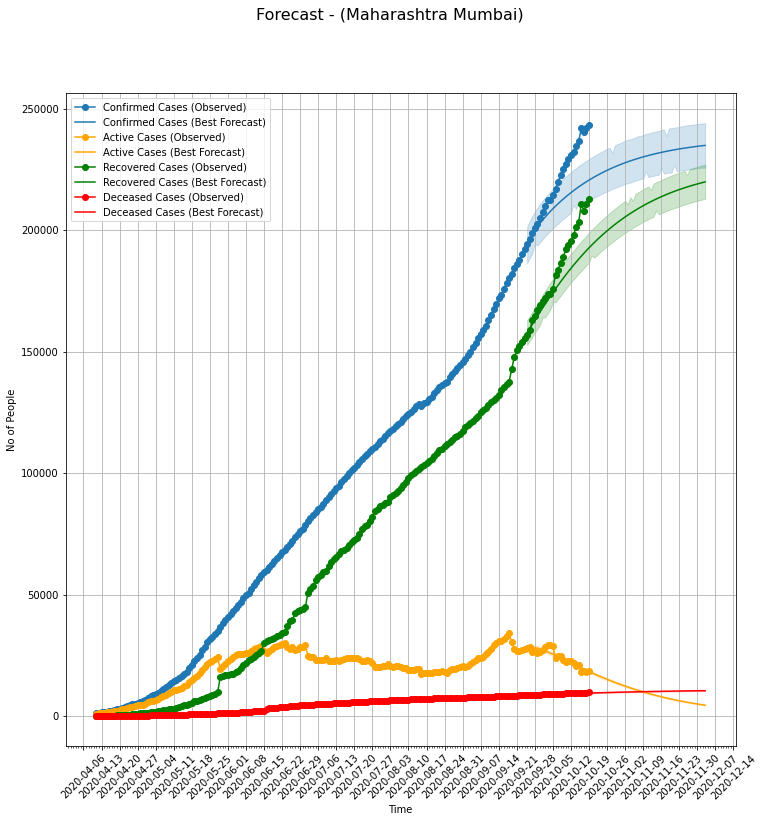

In [54]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [55]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

9it [00:00, 86.94it/s]getting forecasts ..
100it [00:01, 83.44it/s]


In [56]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

7it [00:00, 69.70it/s]getting forecasts ..
100it [00:01, 88.97it/s]


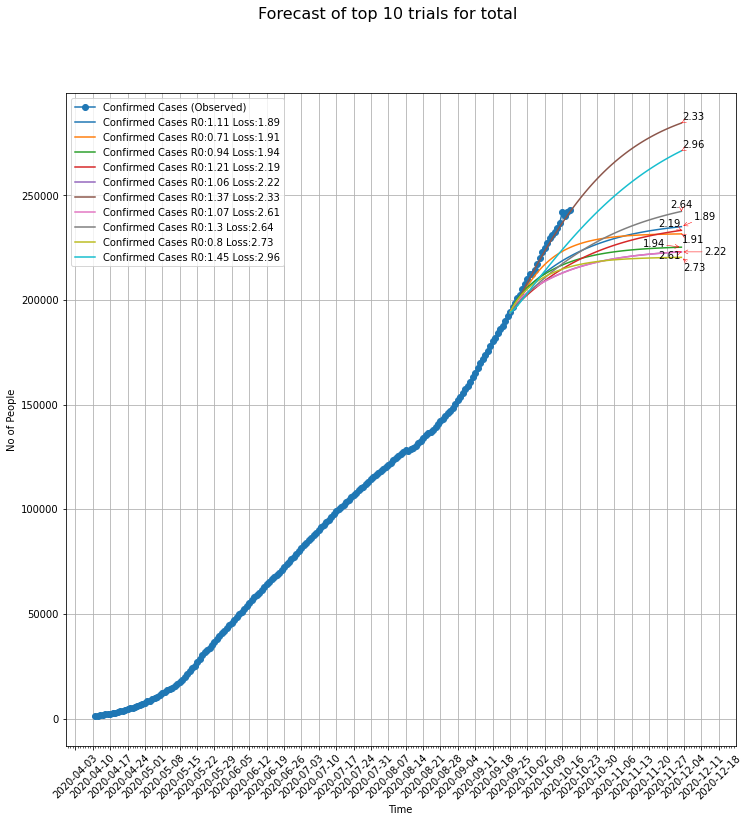

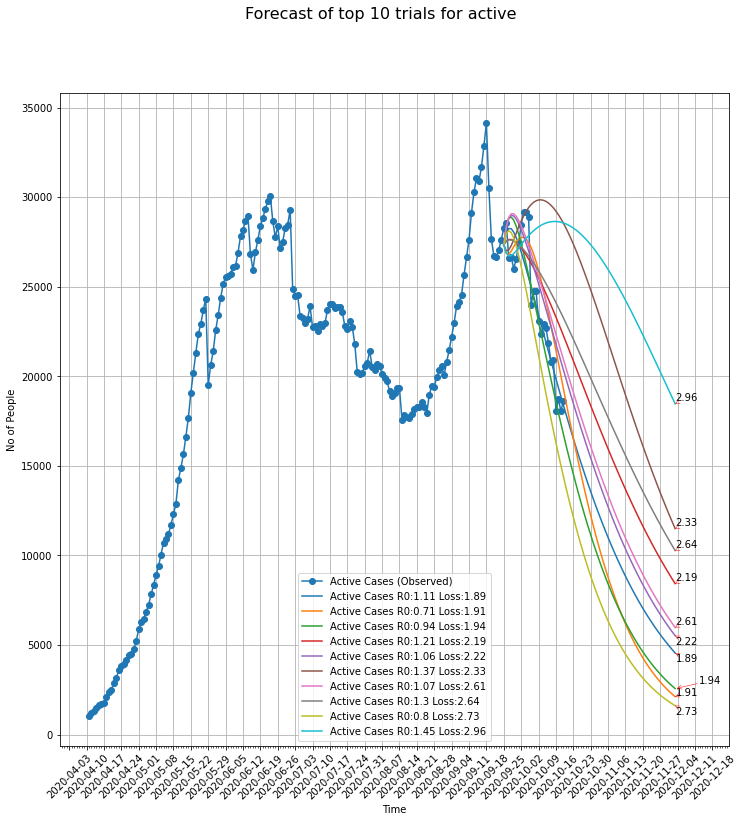

In [57]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [58]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [59]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:05<00:00, 17.35trial/s, best loss: 3.275313209537767]


In [60]:
uncertainty.beta_loss

{'active': 3.6745432537156892,
 'recovered': 3.8513757811724916,
 'deceased': 1.0367653035925248,
 'total': 4.538568499670363}

In [61]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [62]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

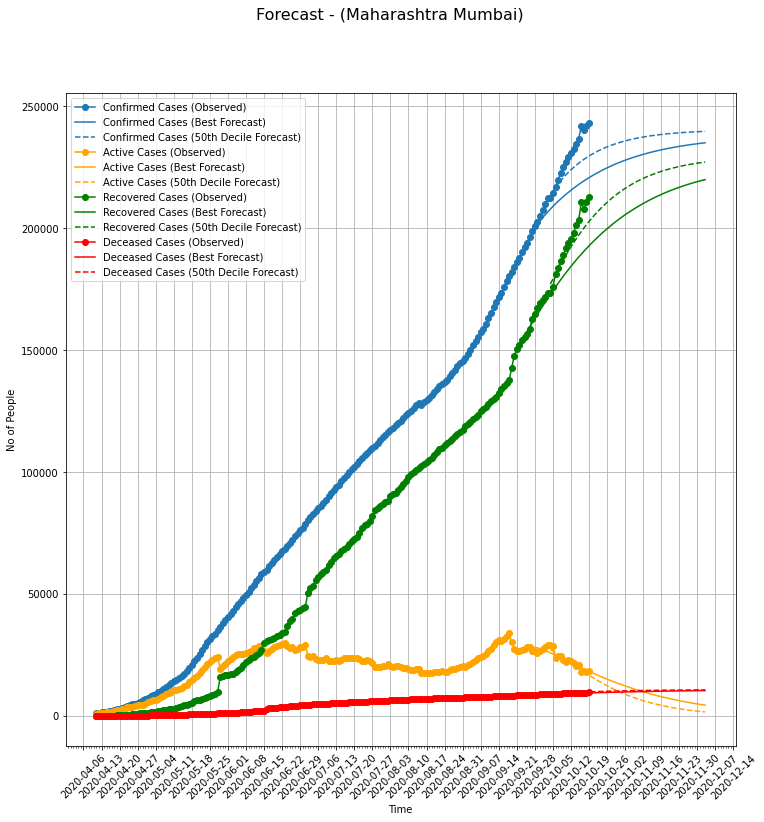

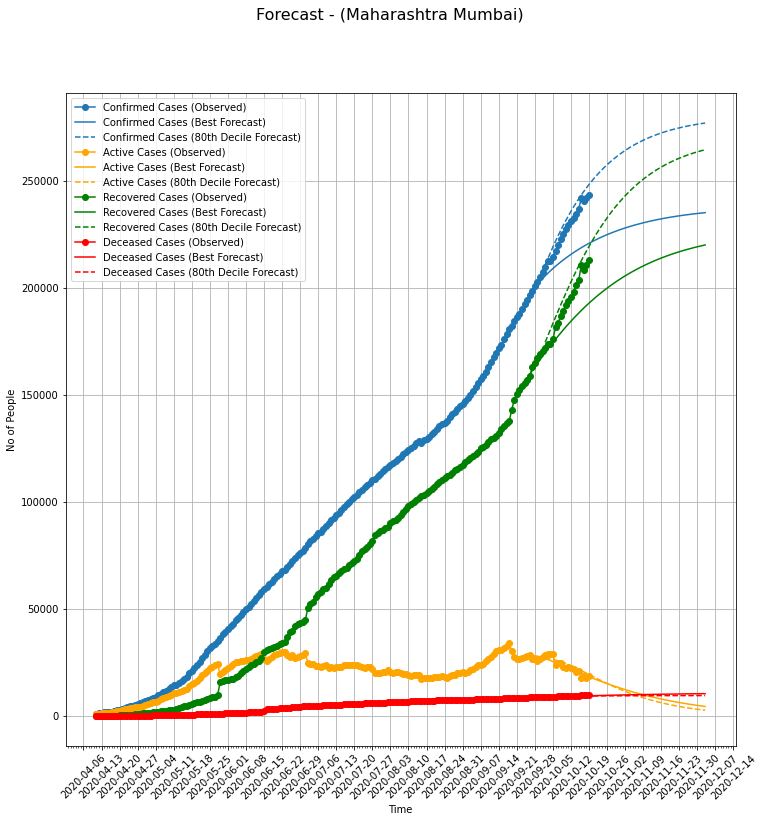

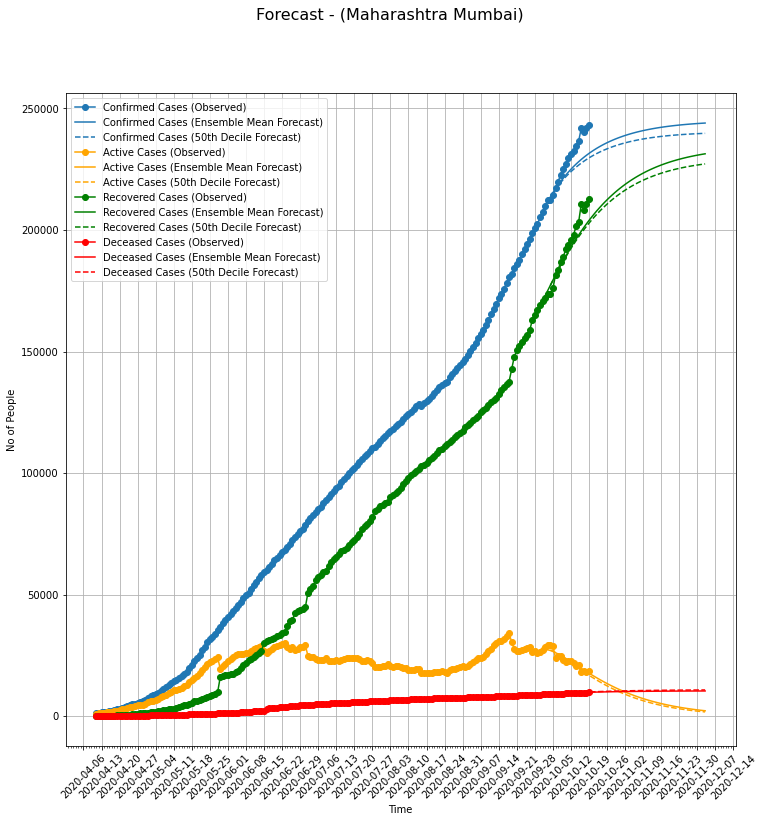

In [63]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

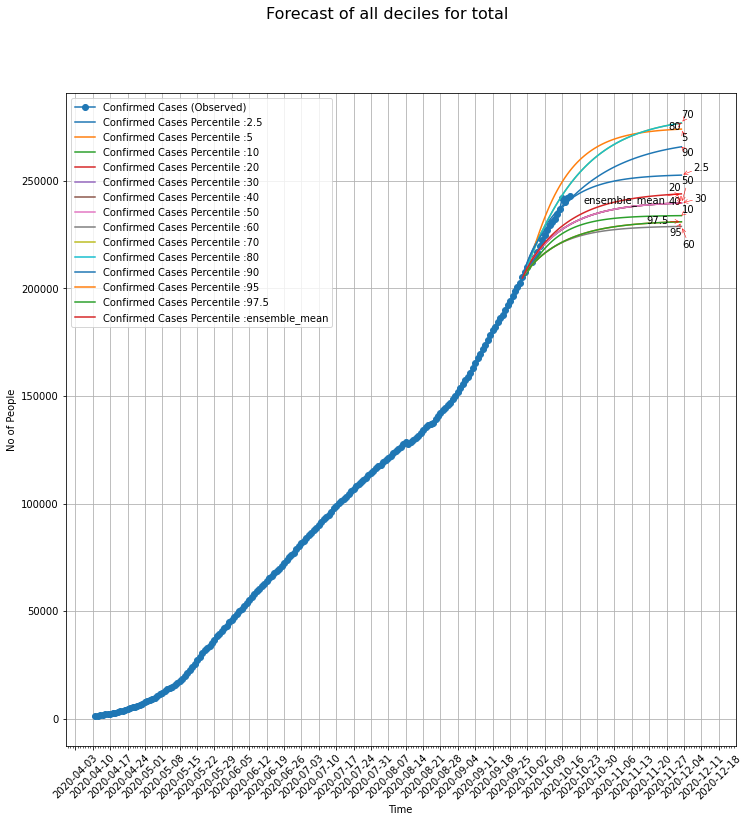

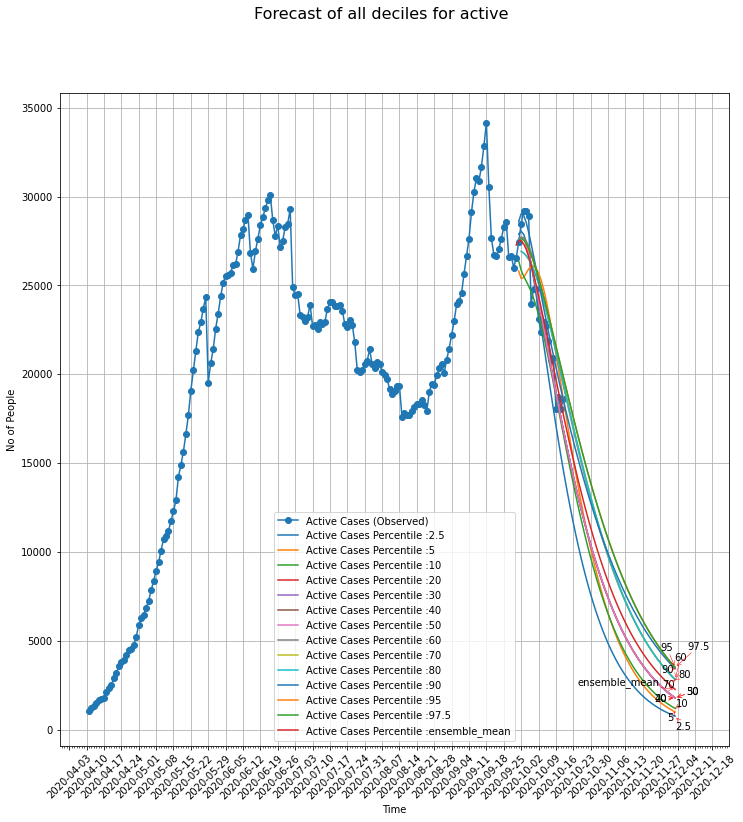

In [64]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


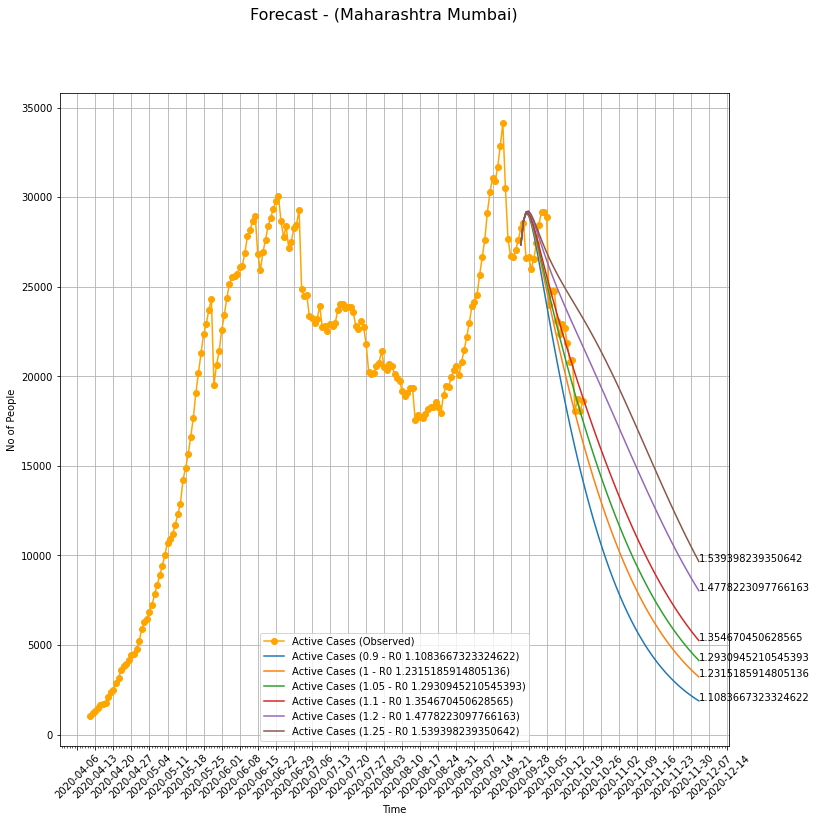

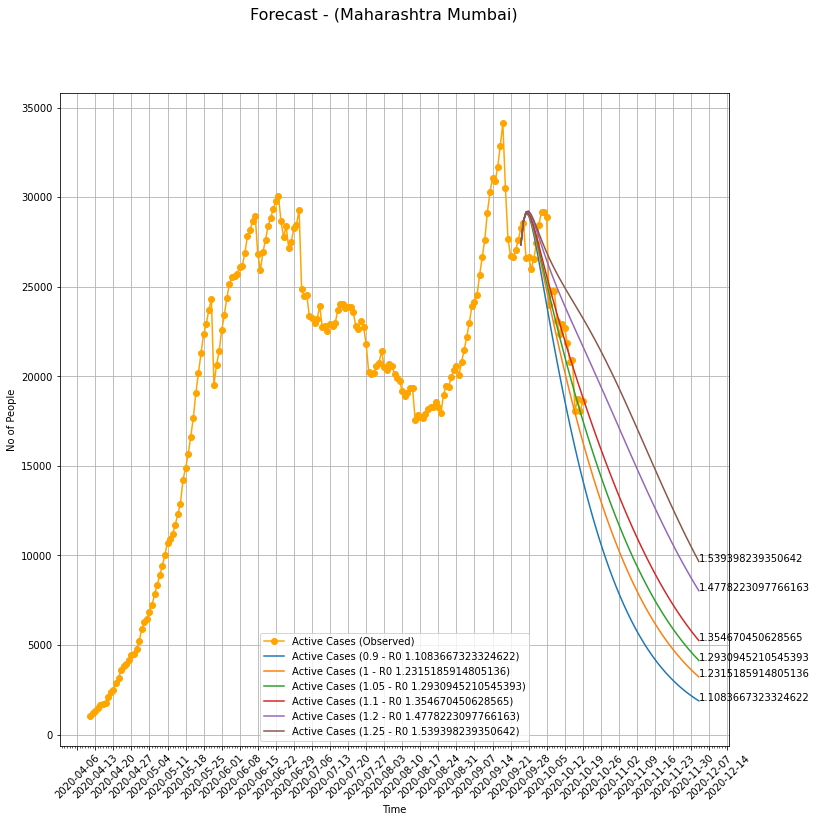

In [65]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_mul_dict = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
plot_r0_multipliers(predictions_dict, None, predictions_mul_dict, None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Create Report

In [66]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [67]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [68]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [69]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Create R0 Multiplier Output

In [70]:
save_r0_mul(predictions_mul_dict, output_folder)

## Create df_district Output

In [71]:
predictions_dict['m1']['df_district'].to_csv(f'{output_folder}/df_district.csv')